In [3]:
%%capture
pip install matplotlib

In [4]:
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import datetime
import pandas
import json
import seaborn as sns
# Set default Seaborn style
sns.set(style="darkgrid")
sns.set_context("talk", font_scale=1.4)
## hides ipython warnings
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (30, 10)
#plt.rcParams['figure.figsize'] = (20, 5)

# General Discussions

## Observe the data
As a first step, we should look at the time series data in question and its various characteristics. Why is this so?  Because a time series may look very different from the another. Therefore they may need very different handling.

1. Check simple moving average and exponential moving average
1. Extract trend, seasonality if any
1. Change level detection - This is not yet done.
1. Check for auto correlation
1. Test for stationarity


## Choosing a model

### Exponential smoothing
Exponential smoothings methods are appropriate for non-stationary data (ie data with a trend and seasonal data).

#### Maths behind the Smoothing methods
Smoothing methods work as weighted averages. Forecasts are weighted averages of past observations. The weights can be uniform (this is a moving average), or following an exponential decay — this means giving more weight to recent observations and less weight to old observations. More advanced methods include other parts in the forecast, like seasonal components and trend components.
1. Simple Exponential Smoothing.
We use this when we have a few data points, Irregular data, No seasonality or trend.
1. Holt’s Linear Trend.
We use this when there is some trend in data, No seasonality.


### ARIMA Models
ARIMA models should be used on stationary data only. One should therefore remove the trend of the data and then model it. This follows sooon

## RMSE measurement
The relevanvce of this comes in when we model a time series and try to understand how accurate its predictions are.



### Load Data

In [5]:
fname = os.path.join("data","metric-cluster.csv")
metric_cluster_df = pandas.read_csv(fname,index_col=0)
metric_cluster_df["value"]=metric_cluster_df["value"].astype(float)
metric_cluster_df.index= pandas.to_datetime(metric_cluster_df.index, infer_datetime_format=True)

fname = os.path.join("data","pv-util.csv")
pv_utilization_df = pandas.read_csv(fname,index_col=0)
pv_utilization_df["value"]=pv_utilization_df["value"].astype(float)
pv_utilization_df.index= pandas.to_datetime(pv_utilization_df.index, infer_datetime_format=True)

#print(metric_cluster_df.index)
#print(pv_utilization_df.index)

# for quick visulation, feel free to uncomment one or more below
#print(metric_cluster_df)
#plt.plot(metric_cluster_df)
#print(pv_utilization_df)
#plt.plot(pv_utilization_df)

# Pick a time series to analyse
- As a sampler, 2 time series are provided. 
- If you want to use metric_cluster_df, uncomment that line below. 
- Or if you want to use pv_utilization_df, uncomment it.
- All analysis accordingly

In [6]:

#series = metric_cluster_df
series = pv_utilization_df

# Observe the data

## Descriptive Stats

In [7]:
import math

print(series.head(2))
print("\nDescriptive Stats:")
print(series.describe())

projInterval=math.ceil((len(series.index))/10)
print("\nNumber of Intervals that we project: ", projInterval)


                         value
timestamp                     
2022-07-07 12:56:46  97.654839
2022-07-07 13:56:46  97.670952

Descriptive Stats:
            value
count  374.000000
mean    97.666059
std      0.005996
min     97.647575
25%     97.662477
50%     97.666422
75%     97.670958
max     97.677208

Number of Intervals that we project:  38


## Check simple moving average and exponential moving average

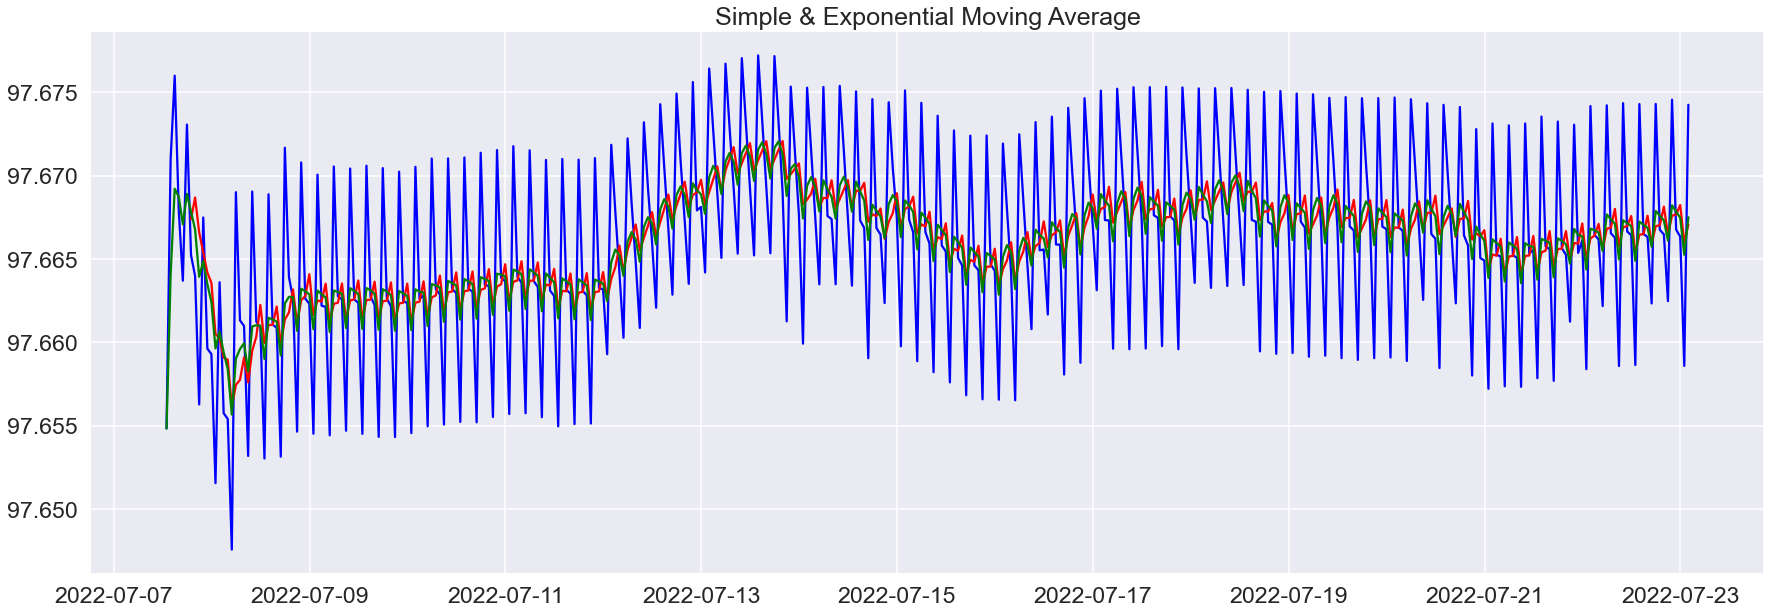

In [8]:
import matplotlib.dates as mdates

#Determing Simple Moving Average
sma = series.value.rolling(window=7).mean()
#Determing Exponential Moving Average
#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.ewm.html
expma = series.value.ewm(span=7).mean()

#fig = plt.figure()

plt.plot(series, color='blue',label='Raw Time series')
plt.plot(sma, color='red', label='Moving Average')
plt.plot(expma, color='green', label = 'Exponential Moving Average')
#plt.xticks(rotation = 45)
##fig.autofmt_xdate()

plt.title('Simple & Exponential Moving Average')
plt.show()


## Extract trend, seasonality if any

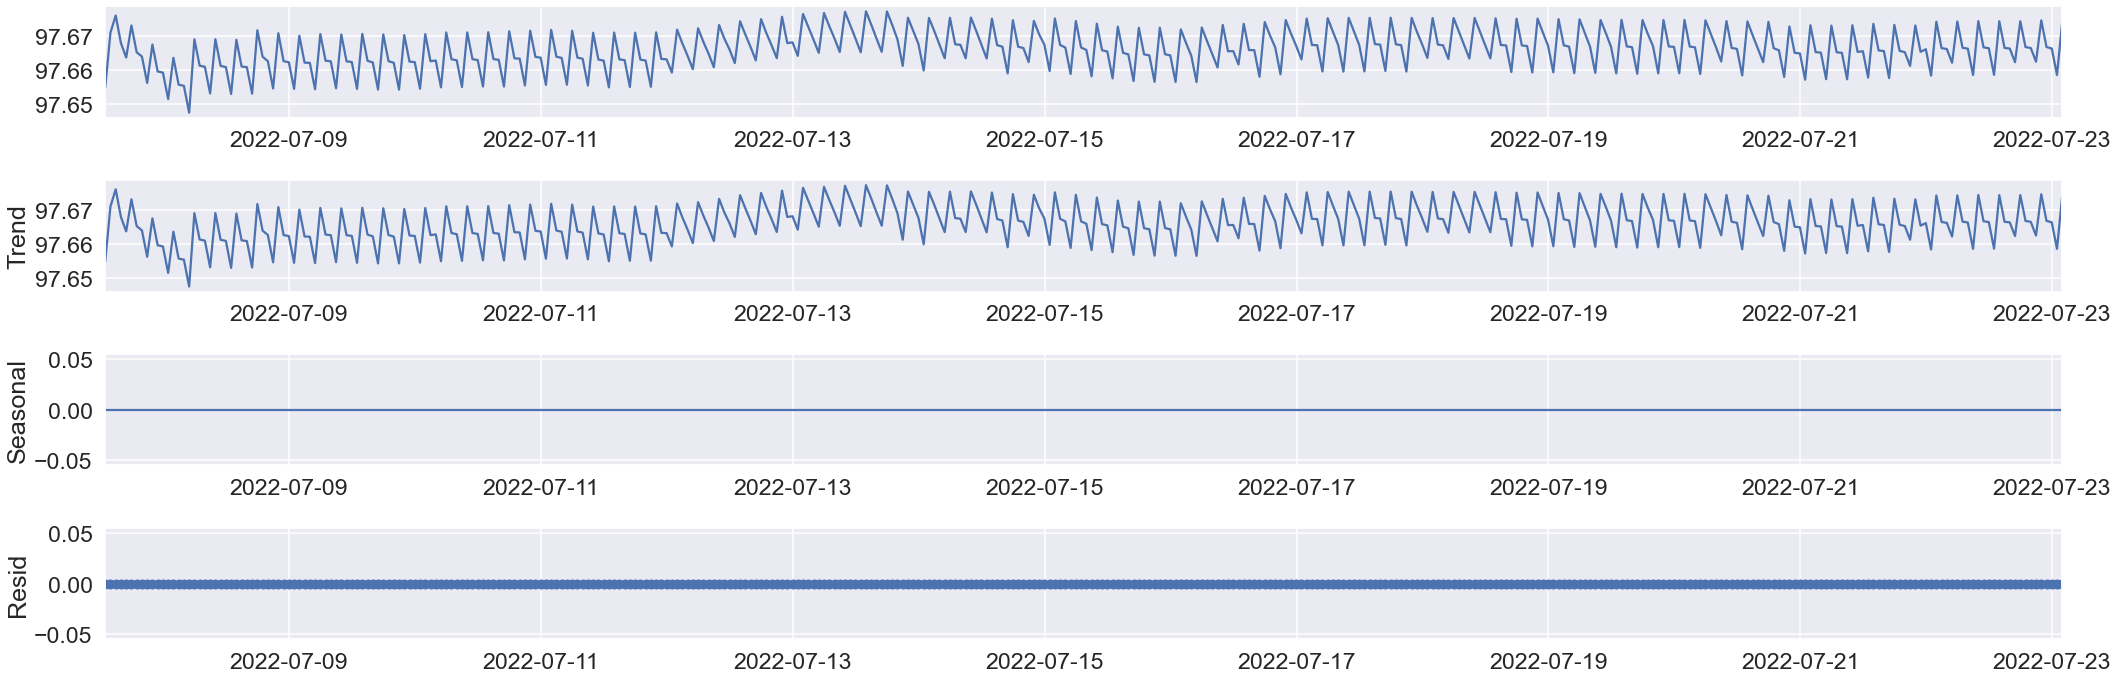

In [15]:

from statsmodels.tsa.seasonal import seasonal_decompose
#see which fits better - additive or multiplicative
result = seasonal_decompose(series, model='additive', period=1)
result.plot()
plt.show()

## Check for auto correlation

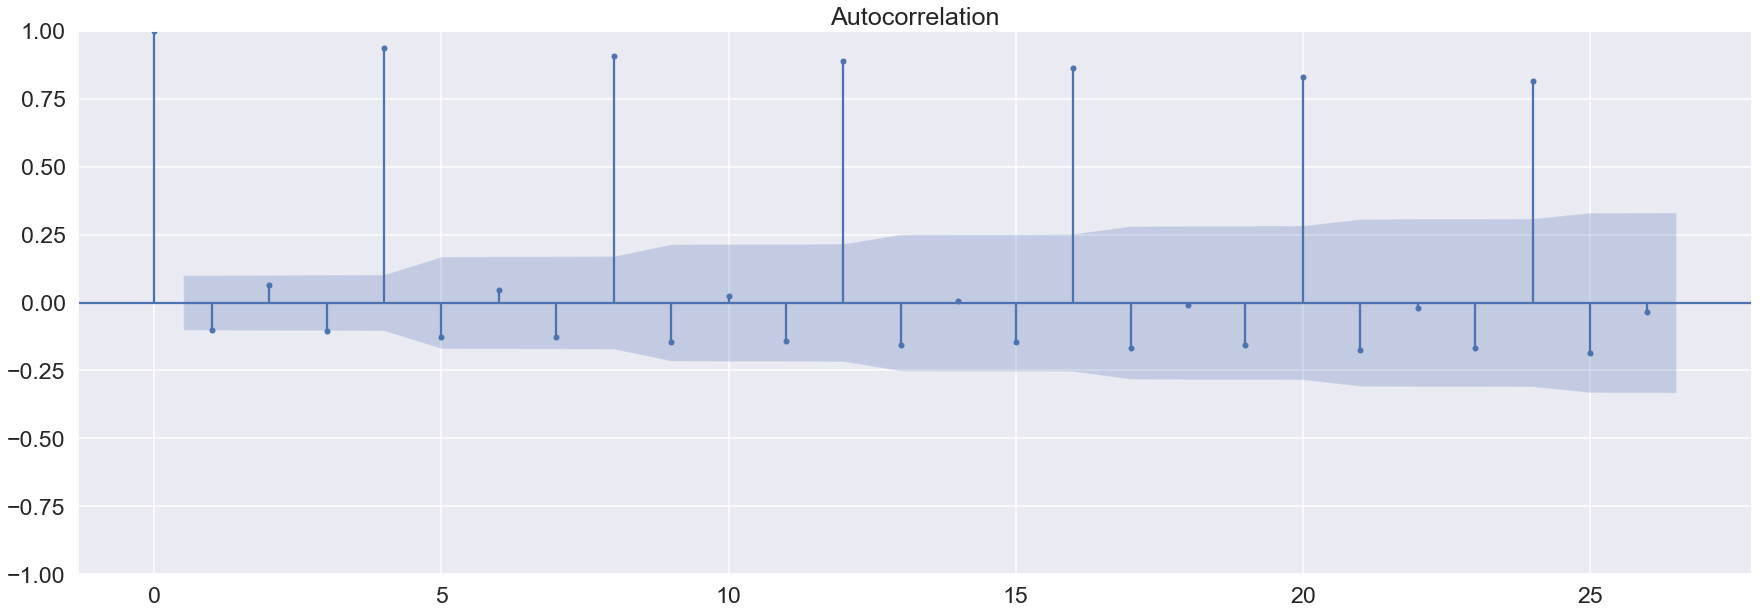

In [10]:
from statsmodels.graphics.tsaplots import plot_acf

ax=plot_acf(series)
plt.show()

## Test for stationarity

In [11]:
from statsmodels.tsa.stattools import adfuller

#returns true if series is stationary.
def is_series_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    isStationary = False
    dftest = adfuller(timeseries, autolag='AIC')
    pValue= dftest[1]
    dfoutput = pandas.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
    #p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
    if pValue <= 0.05:
        print("The time Series is stationary with a ADF Test- pValue: ", pValue)
        isStationary = True
    else:
        print("Transform the time series to make it stationary. It is not a stationary Time series now.")
        isStationary = False
    return isStationary   

In [12]:
is_series_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                  -3.263031
p-value                          0.016614
#Lags Used                      15.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64
The time Series is stationary with a ADF Test- pValue:  0.016614047072773096


True

# Build Model
Now that you have a decent understanding of the data, you can decide which timeseries model to use to deal with the data.

1.Exponential smoothings methods are appropriate for non-stationary data (ie data with a trend and seasonal data).

1.ARIMA models should be used on stationary data only. One should therefore remove the trend of the data (via deflating or logging), and then look at the differenced series.

But one of the key things to understand is the goal of modeling - ie what is the purpose of building a model

### Holt's Linear Trend

/Users/jbanerje/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


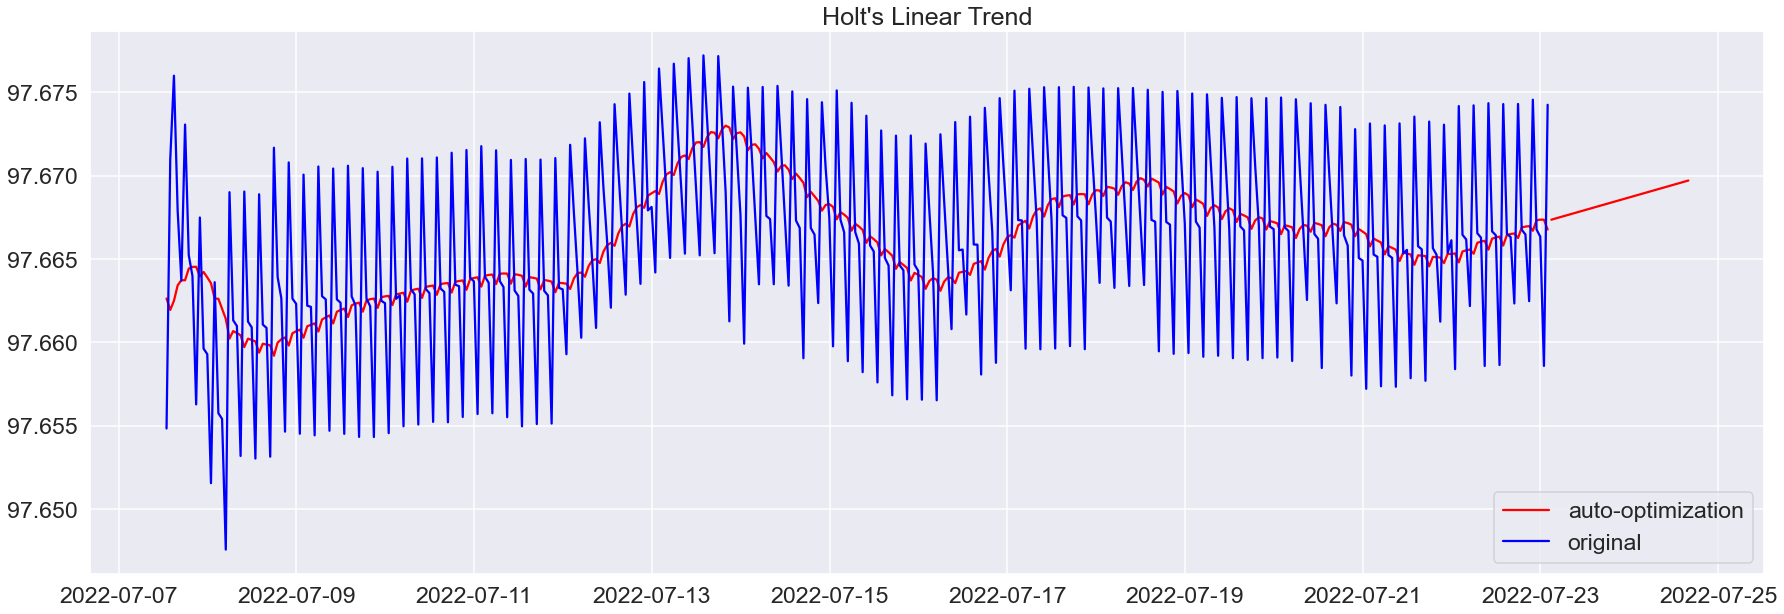

In [13]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

model = Holt(series)

#model._index = pandas.to_datetime(train.index)

#auto optimization
fit1 = model.fit(optimized=True)
pred1 = fit1.forecast(projInterval)

plt.plot(fit1.fittedvalues,color='red',label='auto-optimization')
plt.plot(pred1,color='red')
plt.plot(series,color='blue',label='original')
plt.legend()

plt.title("Holt's Linear Trend") 
plt.show()


### Simple Exponential Smoothening

/Users/jbanerje/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


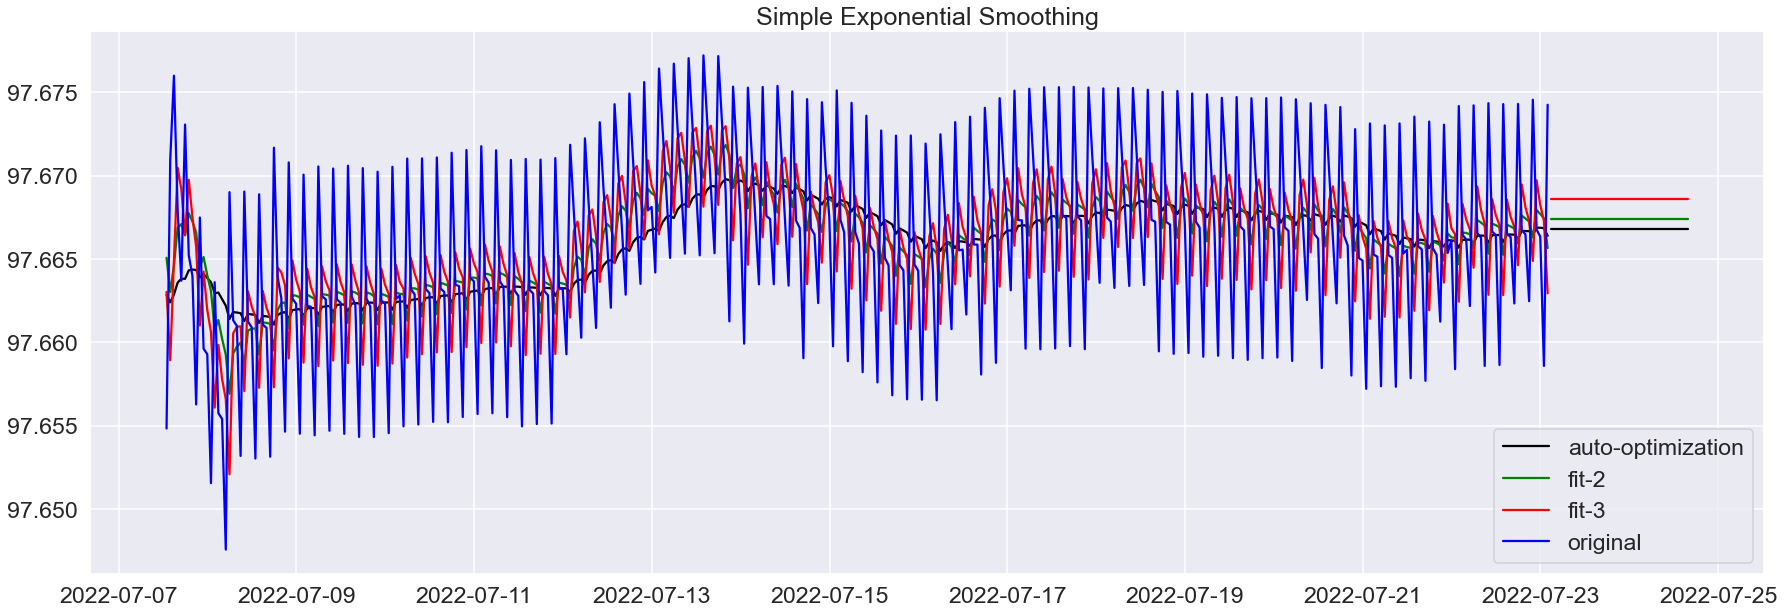

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

model = SimpleExpSmoothing(series)

#model._index = pandas.to_datetime(train.index)

#auto optimization
fit1 = model.fit()
pred1 = fit1.forecast(projInterval)
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(projInterval)
fit3 = model.fit(smoothing_level=.5)
pred3 = fit3.forecast(projInterval)

plt.plot(fit1.fittedvalues,color='black',label='auto-optimization')
plt.plot(fit2.fittedvalues,color='green',label='fit-2')
plt.plot(fit3.fittedvalues,color='red',label='fit-3')
plt.plot(pred1,color='black')
plt.plot(pred2,color='green')
plt.plot(pred3,color='red')
plt.plot(series,color='blue',label='original')
plt.legend()

plt.title("Simple Exponential Smoothing") 
plt.show()


